gnomAD constraints

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from bsmcalls import SNPnexus
from bsmcalls import operations
from matplotlib import pyplot as plt
import attila_utils
%matplotlib inline

See [this page of the MacArthur lab](https://macarthurlab.org/2018/10/17/gnomad-v2-1/) and [this article](https://www.nature.com/articles/s41586-020-2308-7).

In [2]:
data = SNPnexus.load_data('/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.p')

In [3]:
tsvpath = '/home/attila/projects/bsm/results/2021-02-24-gnomad-constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt'
constr = pd.read_csv(tsvpath, delimiter='\t', index_col=0)
constr.shape

(19704, 76)

['named-figure/gnomad-pLI-oe_lof.png', 'named-figure/gnomad-pLI-oe_lof.pdf']

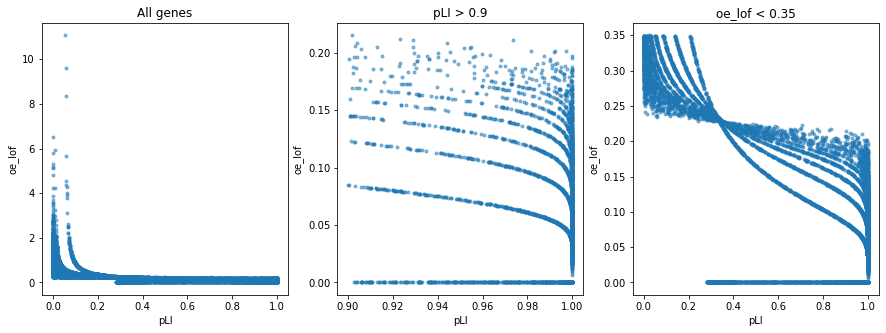

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
def myscatter(ax, data, title):
    ax.scatter(x='pLI', y='oe_lof', data=data, marker='.', alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('pLI')
    ax.set_ylabel('oe_lof')
    return(ax)
ax[0] = myscatter(ax[0], data=constr, title='All genes')
ax[1] = myscatter(ax[1], data=constr.loc[constr.pLI > 0.9], title='pLI > 0.9')
ax[2] = myscatter(ax[2], data=constr.loc[constr.oe_lof < 0.35], title='oe_lof < 0.35')
attila_utils.savefig(fig, 'gnomad-pLI-oe_lof')

In [5]:
constr['pLI > 0.9'] = constr.pLI > 0.9
constr['oe_lof < 0.35'] = constr.oe_lof < 0.35
lof_tab, lof_tab_marg = [pd.crosstab(index=constr['oe_lof < 0.35'], columns=constr['pLI > 0.9'], margins=m) for m in [False, True]]
lof_tab_marg

pLI > 0.9,False,True,All
oe_lof < 0.35,,,
False,12304,0,12304
True,4337,3063,7400
All,16641,3063,19704


In [6]:
pd.DataFrame({test: pd.Series(dict(zip(['oddsratio', 'pvalue'], fun(lof_tab)))) for test, fun in zip(['chi^2', "Fisher's exact"], [stats.chi2_contingency, stats.fisher_exact])})

,chi^2,Fisher's exact
oddsratio,6027.115104,inf
pvalue,0.000000,0.0


In [7]:
genes_pLI, genes_oe_lof = [set(constr.index[constr[condition]]) for condition in ['pLI > 0.9', 'oe_lof < 0.35']]

In [8]:
querydict = {'near_gens_Annotation': ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)'],
             'near_gens_Overlapped Gene': {'genes: pLI > 0.9': genes_pLI, 'genes: oe_lof < 0.35': genes_oe_lof},
            }
results = operations.multiquery(querydict, data, do_sum=False, do_sort=False)

In [9]:
results_vtype = results.xs('near_gens_Annotation', axis=1)[['coding nonsyn', 'coding syn']]
results_constr = results.xs('near_gens_Overlapped Gene', axis=1)

l = [pd.DataFrame({constr: results_vtype[vtype] & results_constr[constr] for constr in results_constr}) for vtype in results_vtype]

results_combi = pd.concat(l, axis=1)
results_combi.columns = pd.MultiIndex.from_product([results_vtype.columns, results_constr.columns])

In [10]:
summary = operations.summarize_query_results(pd.concat([results, results_combi], axis=1), data)
summary

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Control  SCZ  ASD   All  \
Feature                   Query                                             
near_gens_Annotation      coding nonsyn                23   43   23    89   
                          coding syn                   16   20   15    51   
                          missense                      0    0    0     0   
                          stop-gain                     1    0    0     1   
                          intronic (splice_site)        0    1    0     1   
near_gens_Overlapped Gene genes: pLI > 0.9            220  361  298   879   
                          genes: oe_lof < 0.35        410  667  531  1608   
coding nonsyn             genes: pLI > 0.9              8   10   10    28   
                          genes: oe_lof < 0.35         13   17   14    44   
coding syn                genes: pLI > 0.9              2    4    5    11   
                          genes: oe_lof < 0.35          6    8    8    22   

                                                  chisq stat   chisq p  
Feature                   Query                                         
near_gens_Annotation      coding nonsyn             4.480340  0.106440  
                          coding syn                1.177849  0.554924  
                          missense                       NaN       NaN  
                          stop-gain                 2.887477  0.236044  
                          intronic (splice_site)    1.582797  0.453210  
near_gens_Overlapped Gene genes: pLI > 0.9          2.099016  0.350110  
                          genes: oe_lof < 0.35      6.110077  0.047121  
coding nonsyn             genes: pLI > 0.9          0.153703  0.926028  
                          genes: oe_lof < 0.35      0.423043  0.809352  
coding syn                genes: pLI > 0.9          0.561910  0.755062  
                          genes: oe_lof < 0.35      0.056021  0.972378

In [11]:
%connect_info

{
  "shell_port": 57219,
  "iopub_port": 35515,
  "stdin_port": 45861,
  "control_port": 46035,
  "hb_port": 53517,
  "ip": "127.0.0.1",
  "key": "db1bd78d-f9706b55cf1a5e973a62d4bc",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d8e699e5-ea95-41ee-ab9e-d082397e506d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
